# Base Definition

In [ ]:
! pip install seaborn
! pip install latex
! pip install jaxlib 
! pip install haiku
! pip install optax
! pip install tqdm
! pip install diffrax
! pip install pickle

In [1]:
import warnings
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union
import jax # Numerical computing library for GPU/TPU accelerators
import jax.random as jr
import jax.numpy as jnp
import optax # Optax: A gradient processing and optimization library for JAX
import haiku as hk # Haiku: A neural network library for JAX
import numpy as np
from scipy.interpolate import griddata
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns # Seaborn: A statistical data visualization library
import os.path
import pickle
import math

# Diffrax library imports
from diffrax import (
    diffeqsolve,
    ControlTerm,
    Euler,
    MultiTerm,
    ODETerm,
    SaveAt,
    VirtualBrownianTree,
    WeaklyDiagonalControlTerm
)

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

In [14]:
# Define all hyper params here

g = 0.03 # Parameter in the model
lambda_ = 0.5 # Parameter in the model
t0, t1 = 0.0, 10.0 # Time range for the simulation
EPSILON = 1e-5 # Small constant to prevent division by zero or other numerical issues
num_path_dataset = 500 # Number of paths generated in generate.ipynb
ema_decay=0.9 # Exponential moving average decay factor
ema_loss = 0.0 # Initial value for exponential moving average loss
dpi = 200 # Dots per inch for plotting resolution
height = 6 # Height of the plot
width = 4  # Width of the plot
scaling_factor = 1. # Scaling factor for the domain
snap_shot_gap = 100 # Snapshot frequency during training
# Define global settings here

seed = 2022
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})
sns.set(font_scale=1.5, rc={'text.usetex' : False})
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white', 'axes.labelcolor' : "black", 'text.color' : "black"})



## Physics System SDE

We consider the SDE function defined by $dx = - \lambda sign(x) x^2 dt + g dW$ with $\lambda = 7$ and $g = 0.03$ which is easy to find a solution by SDE solver.


In [8]:
physics_operator = lambda x: - jnp.sign(x) * x * x * lambda_

def r_process(initial_value, noise_scaling, seed):
    """
    Simulates a stochastic process using the Euler method.

    Parameters:
    - initial_value (float): Initial value of the process.
    - noise_scaling (float): Scaling factor for the diffusion term (stochastic component).
    - seed (int): Seed for random number generation.

    Returns:
    - sol (numpy.ndarray): Solution of the stochastic process over the specified time interval.
    """
    initial_shape = (1,)
    y0 = jnp.ones(shape=initial_shape) * initial_value
    drift = lambda t, y, args: physics_operator(y)

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=jr.PRNGKey(seed))
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(dense=True)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=y0, saveat=saveat)
    
    return sol

A simulation to the random SDE using solver

/home/lujun/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/lujun/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/lujun/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/lujun/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_u

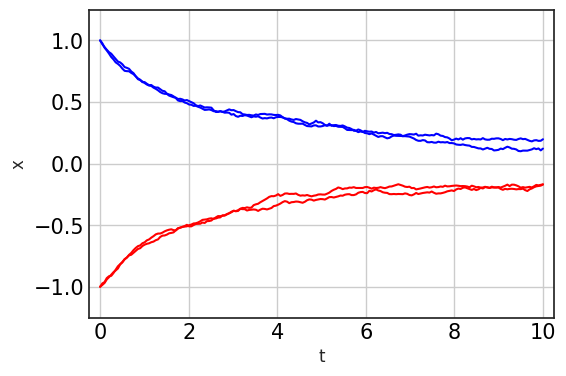

In [11]:
with plt.style.context("seaborn-white"):

    value_one = [r_process(1.0, g, seed+n) for n in range(0, 2)]
    value_minus_one = [r_process(-1.0, g, seed+n) for n in range(2, 4)]

    fig, ax = plt.subplots(figsize=(6,4))

    x = jnp.linspace(0,10,200)
    
    for i in range(2):
    
        sol = value_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')

        sol = value_minus_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([-0.25, 10.25])
    plt.ylim([-1.25,1.25])

    plt.show()

In [3]:
if os.path.isfile('test_sample_data.p'):
    with open('test_sample_data.p', 'rb') as file:
        dataset = pickle.load(file)
        data = jnp.array(dataset)

Preprossing dataset functions

In [6]:
def _prepare_batch(batch):
    """
    Preprocesses a batch of data for input to a model.

    Parameters:
    - batch (numpy.ndarray): Input batch data.

    Returns:
    - Tuple[numpy.ndarray, numpy.ndarray]: Processed input batch (batch_x, batch_t).
    """
    batch_x = batch[:,::-1]
    batch_t = jnp.linspace(0,10, batch_x.shape[1])[::-1]

    return (batch_x, batch_t)

def iterbatches(X, batch_size, shuffle=False):
    """
    Generates batches of data for training or evaluation.

    Parameters:
    - X (numpy.ndarray): Input data.
    - batch_size (int or None): Size of each batch. If None, the entire dataset is used as a single batch.
    - shuffle (bool): Whether to shuffle the data before creating batches.

    Yields:
    - numpy.ndarray: Batch of data.
    """
    
    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]
        
        ids = np.arange(n_samples)
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)
            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
            ids_batch = ids[perm_indices]
          
            batch_idx += 1
            yield X_batch

    return iterate(X, batch_size, shuffle)

# For visulisation initialisation
def _prepare_batch_grid(batch):
    """
    Preprocesses a batch of data for input to a model with grid-based structure.

    Parameters:
    - batch (numpy.ndarray): Input batch data.

    Returns:
    - List[List[numpy.ndarray]]: Processed input batch with grid-based structure.
    """
    inputs = [np.split(x, x.shape[1], 1) for x in batch]
    return inputs

def iterbatches_grid(X, batch_size, shuffle=False):
    """
    Generates batches of grid-based data for training or evaluation.

    Parameters:
    - X (numpy.ndarray): Input grid-based data.
    - batch_size (int or None): Size of each batch. If None, the entire dataset is used as a single batch.
    - shuffle (bool): Whether to shuffle the data before creating batches.

    Yields:
    - List[numpy.ndarray]: Batch of grid-based data.
    """
    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]
        
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)
          
            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
          
            batch_idx += 1
            yield ([X_batch])

    return iterate(X, batch_size, shuffle)

## Neural Network for Score Matching Approximation

In [10]:
# Structure of the neural network and initialisation
def f(x, t):
    t = jnp.log(t + EPSILON)
    x = jnp.hstack([x, t])
    net = hk.nets.MLP(output_sizes = [30, 30, 25, 20, 10, 1],
                    activation = jax.nn.elu)
    return net(x)

init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(0)

x_init = jnp.ones((10,1))
t_init = x_init
params = init_params(rng, x_init, t_init)

Define a function to evaluate the model and a function that implements the backpropagation and updating of parameters given the optimizer and model loss

In [18]:
def create_eval_fn(forward_fn, params):
    """
    Creates an evaluation function for a given forward model.

    Parameters:
    - forward_fn (Callable): Forward model function.
    - params (hk.Params): Model parameters.

    Returns:
    - Callable: Evaluation function.
    """
    @jax.jit
    def eval_model(t, x, rng=None):
        """
        Evaluates the forward model.

        Parameters:
        - t (float): Time parameter.
        - x (jnp.ndarray): Input data.
        - rng (jax.random.PRNGKey, optional): Random number generator key.

        Returns:
        - jnp.ndarray: Model evaluation result.
        """
        res = forward_fn(params, rng, x, t)
        return res
    return eval_model

def create_default_update_fn(optimizer: optax.GradientTransformation,
                             model_loss: Callable):
    """
    Creates a default update function for back propagation.

    Parameters:
    - optimizer (optax.GradientTransformation): Optimization algorithm.
    - model_loss (Callable): Model loss function.

    Returns:
    - Callable: Update function.
    """
    @jax.jit
    def update(params, opt_state, batch, rng) -> Tuple[hk.Params, optax.OptState, jnp.ndarray]:
       
        batch_loss, grads = jax.value_and_grad(model_loss)(params, rng, *batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, batch_loss
    return update

ODE solver for the probability flow ODE using Euler Steps

In [19]:
# Multistep loss
def gradient_fn(forward_fn, physics_operator, g):
    """
    Creates a multistep loss function for training a model.

    Parameters:
    - forward_fn (Callable): Forward model function.
    - physics_operator (Callable): Physics operator function.
    - g (float): Some parameter 'g'.

    Returns:
    - Callable: Multistep loss function.
    """
    
    @jax.jit
    def model_loss(model_weights, rng, x_train, t_train):
        
        x = x_train[:,0]
        i = 1
        loss = 0.0
        for t1, t0 in zip(t_train, t_train[1:]):
            delta_t = t1-t0
            physics_update = physics_operator(x)
            score_update = - 0.5 * forward_fn(model_weights, rng, jnp.expand_dims(x, axis=1), 
                                              jnp.repeat(jnp.tile(t1, 1)[None], x.shape[0], axis=0))[:,0]
            x = x - delta_t * (physics_update + score_update)
            x_true = x_train[:,i]
            loss += jnp.mean(jnp.square(x - x_true))
            i += 1
        return loss

    return model_loss

# Jump loss
def gradient_fn_cumulative(forward_fn, physics_operator, g):

    @jax.jit
    def model_loss(model_weights, rng, x_train, t_train):
        
        x = x_train[:,0]
        i = 1
        x_true_initial = x
        for t1, t0 in zip(t_train, t_train[1:]):
            delta_t = t1-t0
            physics_update = physics_operator(x)
            score_update = - 0.5 * forward_fn(model_weights, rng, jnp.expand_dims(x, axis=1), 
                                              jnp.repeat(jnp.tile(t1, 1)[None], x.shape[0], axis=0))[:,0]
         
            x = x - delta_t * (physics_update + score_update)

            i += 1
    
        # Calculate initial-to-final MSE for the entire trajectory
        loss = jnp.mean(jnp.square(x - x_true_initial))
        return loss

    return model_loss

# Exponential moving average EMA Loss
def gradient_fn_EMA(forward_fn, physics_operator, g):

    @jax.jit
    def model_loss(model_weights, rng, x_train, t_train):
        
        x = x_train[:,0]
        i = 1

        for t1, t0 in zip(t_train, t_train[1:]):
            delta_t = t1-t0
            physics_update = physics_operator(x)
            score_update = - 0.5 * forward_fn(model_weights, rng, jnp.expand_dims(x, axis=1), 
                                              jnp.repeat(jnp.tile(t1, 1)[None], x.shape[0], axis=0))[:,0]
            x = x - delta_t * (physics_update + score_update)
            x_true = x_train[:, i]
            current_loss = jnp.mean(jnp.square(x - x_true))
            ema_loss = ema_decay * ema_loss + (1 - ema_decay) * current_loss
            i += 1
        return ema_loss
    return model_loss


In [20]:
# Define a grid of points in the x-y plane
x_ = np.linspace(0., 10., 400)
y_ = np.linspace(-1.25, 1.25, 200)
X, Y = np.meshgrid(x_,y_)
full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
meshgrid = (X,Y)

def save_snapshot_score(params, forward_fn, meshgrid, step=None, savename=None):

    """
    Save a visualization snapshot of the model's predictions on a given meshgrid.

    Parameters:
    - params (hk.Params): Model parameters.
    - forward_fn (Callable): Forward model function.
    - meshgrid (Tuple[np.ndarray, np.ndarray]): Meshgrid in the x-y plane.
    - step (int, optional): Training step or iteration number.
    - savename (str, optional): Name to use for saving the snapshot.

    Returns:
    - None
    """
    eval_fn = create_eval_fn(forward_fn, params)
    results = None
    X, Y = meshgrid
    full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    
    full_domain_scaled = full_domain * scaling_factor
    
    generator = iterbatches_grid(full_domain_scaled, 1000, shuffle=False)
    for batch in generator:
        inputs = _prepare_batch_grid(batch)
        
        output_values = eval_fn(*inputs[0], rng)
        if isinstance(output_values, jnp.ndarray):
            output_values = [output_values]
        output_values = [jax.device_get(t) for t in output_values]

        if results is None:
            results = [[] for i in range(len(output_values))]
        for i, t in enumerate(output_values):
            results[i].append(t)

    final_results = []
    if results is not None:
        for r in results:
            final_results.append(np.concatenate(r, axis=0))
    
    x_scaled = x_ * scaling_factor
    y_scaled = y_ * scaling_factor
    meshgrid_scaled = (meshgrid[0] * scaling_factor, meshgrid[1] * scaling_factor)
    
    fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(height,width))
    fig.set_dpi(dpi)
    
    ax = axes  

    u_pred = final_results[0][:].flatten()
    U_pred = griddata(full_domain_scaled, u_pred.flatten(), meshgrid_scaled, method='cubic')
   
    vmax = 75 
    h = ax.imshow(jnp.flip(U_pred / (g**2), axis=0), cmap='jet', 
                  extent=[ x_scaled.min(), x_scaled.max(), y_scaled.min(), y_scaled.max()], 
                  aspect='auto', vmin = -vmax, vmax = vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15) 
    ax.set_xlabel(r"$t$", color="black", size=20)
    ax.set_ylabel(r"$x$", color="black", size=20)
 
    ax.tick_params(labelsize=15)
    
    axTransform = {'horizontalalignment':'right',
             'verticalalignment':'center', 'transform':ax.transAxes}
    
    ax.grid(False)
    
    ax.patch.set_edgecolor('black') 
    ax.patch.set_linewidth('1')  
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    
    if savename:
        plt.savefig(f'result/{savename}.svg', transparent=True)

    plt.show()

## Training

In [21]:
def update_network(params_, forward_fn, dataset, rng, steps = 20, ROLLOUT_increases = 18, max_training_time=None, 
                   ROLLOUT_start = 4, ROLLOUT_add = 2, lr=5e-4, bidirectional=False, subsample=5, fn =gradient_fn, fn_name = ""):
    
    # Learning rate 
    scheduler = optax.piecewise_constant_schedule(
        init_value=lr)
    
    # Optax otimizer using Adam
    opt = optax.chain(
        optax.scale_by_adam(b1=0.9, b2=0.99),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0))
    opt_state = opt.init(params_)
    
    # Define model loss and update for network parameters
    model_loss_fn = fn(forward_fn, physics_operator, g)
    grad_update = create_default_update_fn(opt, model_loss_fn)
    
    avg_loss = 0
    grad_updates = 0
    
    ROLLOUT = ROLLOUT_start
    history = []
    
    # Iterate through all sliding window sizes
    for _ in range(ROLLOUT_increases+1):
        
        print('Window size: ', ROLLOUT)
        
        pbar = tqdm(range(steps))
        
        # Iterate through all epochs
        for n in pbar:

            # Iterate through data set
            generator = iterbatches(dataset, 256, shuffle=False)
            for batch in generator:
                x_train, t_train = _prepare_batch(batch)
                
                
                # Concentrate on specific parts of trajectory
                if max_training_time is not None:
                    
                    x_train = x_train[:, -max_training_time:]
                    t_train = t_train[-max_training_time:]
                
                
                # Use subsampling to reduce number of points on trajectory
                x_train = x_train[:, ::subsample]
                t_train = t_train[::subsample]
                
                
                # Iterate through trajectory
                for t in range(x_train.shape[1]):
                    
                    # Select values based on position and window size
                    x_train_sub = x_train[:, t:t+ROLLOUT]
                    t_train_sub = t_train[t:t+ROLLOUT]
                   

                    # Compute loss for current part of trajectory
                    params_, opt_state, batch_loss_backward = grad_update(params_, opt_state, [x_train_sub, t_train_sub], rng=rng)
                    
                    # Reverse values and time discretization for the forward time direction
                    if bidirectional:
                        params_, opt_state, batch_loss_forward = grad_update(params_, opt_state, 
                                                                             [x_train_sub[:,::-1], t_train_sub[::-1]], rng=rng)
                    
                    grad_updates += 1

                    rng, _ = jax.random.split(rng)
                    avg_loss += jax.device_get(batch_loss_backward)
                    if bidirectional:
                        avg_loss += jax.device_get(batch_loss_forward)
                        
                    history.append(batch_loss_backward+batch_loss_forward)

            pbar.set_description(f'loss: {avg_loss/(n+1):.5f} grad updates: {grad_updates}')
            
            if n % snap_shot_gap ==0:
                # Plot score field for each window size
                with plt.style.context("seaborn-white"):
                    save_snapshot_score(params_, forward_fn, meshgrid, savename=f'score_field_{ROLLOUT}_{n}_loss_{fn_name}')
        ROLLOUT += ROLLOUT_add 
    
    return params_, history

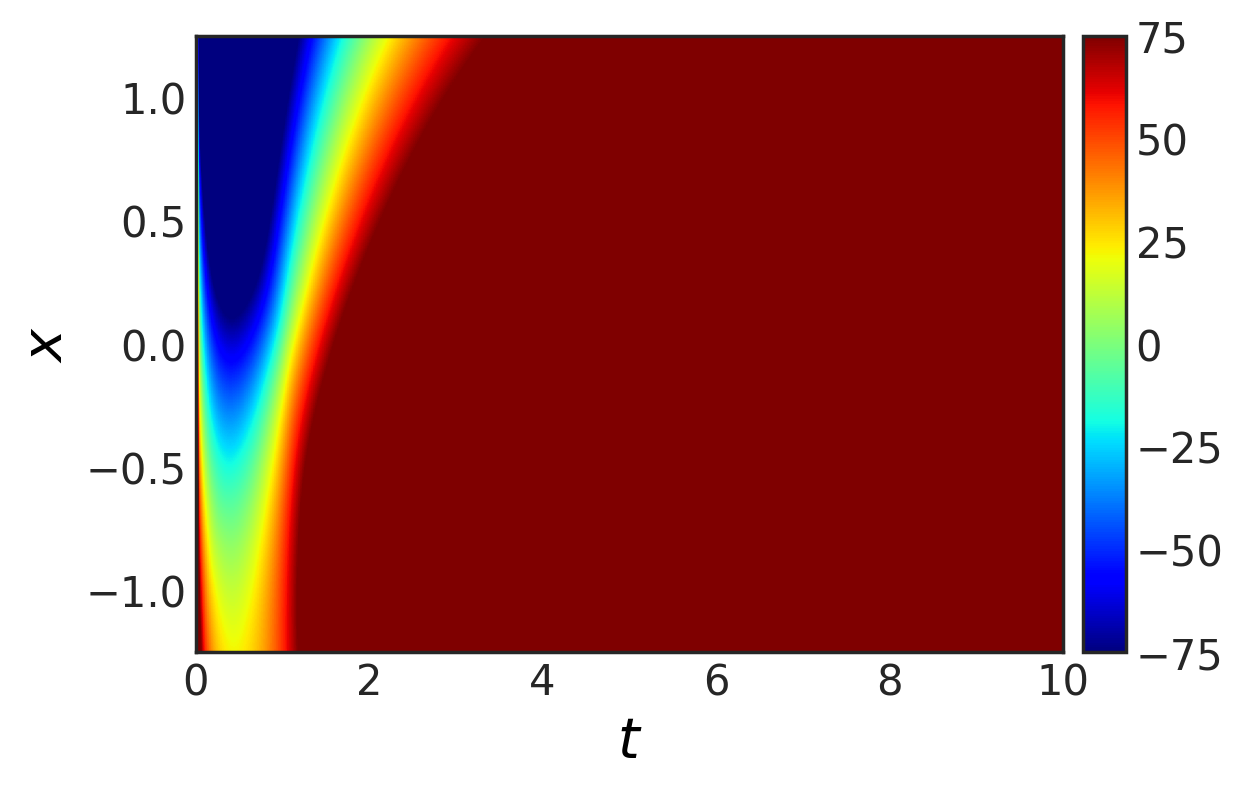

In [22]:
# Save the score field beofre any training
with plt.style.context("seaborn-white"):
    save_snapshot_score(params, forward_fn, meshgrid)

In [ ]:
key = jax.random.PRNGKey(seed)
# Do Training and save the snapshort of score filed every 100 steps
params_single_step_gradient_fn_cumulative_subsample_5_roll_2, history = update_network(params, forward_fn, data, key, steps = 1001, 
                                             ROLLOUT_start=2, ROLLOUT_increases=0, bidirectional=True, lr=1e-4, 
                                             subsample=5,fn=gradient_fn_cumulative, fn_name="gradient_fn_cumulative_subsample_5")


params_single_step_gradient_fn_EMA_subsample_5, history = update_network(params, forward_fn, data, key, steps = 1001, 
                                             ROLLOUT_start=2, ROLLOUT_increases=0, bidirectional=True, lr=1e-4, 
                                             subsample=5,fn=gradient_fn_EMA, fn_name="gradient_fn_EMA_subsample_5")